In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## File Naming

In [2]:
file_path = "content/mydog/train/"

In [3]:
print(file_path)

content/mydog/train/


In [4]:
label_name_list = os.listdir(file_path)

In [5]:
print(label_name_list)

['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']


In [12]:
for label_name in label_name_list:
    file_names = os.listdir(file_path + label_name)
    #print(file_names)
    
    img_list = glob.glob(file_path + label_name + "/*.*")
    print(len(file_names), len(img_list))

144 144
331 331
135 135
156 156


In [15]:
for label_name in label_name_list:
    label_dir_name = os.path.join(file_path, label_name)
    print(label_dir_name)
    
    file_list = os.listdir(label_dir_name)
    cnt = 1
    for file_name in file_list:
        src_file_name = label_dir_name + "/" + file_name
        dst_file_name = label_dir_name + "/" + label_name + "." + \
                        str(cnt) + ".jpg"
        
        os.rename(src_file_name, dst_file_name)
        cnt = cnt + 1
        
    print(cnt, "file are renamed!")

content/mydog/train/chihuahua
145 file are renamed!
content/mydog/train/jindo_dog
332 file are renamed!
content/mydog/train/shepherd
136 file are renamed!
content/mydog/train/yorkshire_terrier
157 file are renamed!


## Project-1

### 경로 설정

In [24]:
ROOT_DIR = "content"

In [25]:
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "mydog")

In [29]:
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")

In [30]:
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

In [50]:
TEST_IMAGE_FILE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test_image_files")

In [73]:
TEST_IMAGE_FILE_DATA_ROOT_DIR

'content\\mydog\\test_image_files'

In [18]:
if os.path.exists(os.path.join(ROOT_DIR, "mydog")):
    shutil.rmtree(os.path.join(ROOT_DIR, "mydog"))
    print(os.path.join(ROOT_DIR, "mydog") + " is deleted!")

content\mydog is deleted!


In [21]:
with zipfile.ZipFile(os.path.join(ROOT_DIR, "mydog.zip"), "r") as target_file:
    target_file.extractall(os.path.join(ROOT_DIR))

In [22]:
label_name_list = os.listdir(os.path.join(ROOT_DIR, "mydog/train/"))
print("total : ", len(label_name_list))
print("-------------------------------")
print(label_name_list)

total :  4
-------------------------------
['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']


- test디렉토리와 test_image_files 디렉토리 생성
    - train에서 test디렉토리로 move
    - test에서 test_image_files로 copy

In [23]:
if not os.path.exists(os.path.join(ROOT_DIR, "mydog/test")):
    os.mkdir(os.path.join(ROOT_DIR, "mydog/test"))
    
if not os.path.exists(os.path.join(ROOT_DIR, "mydog/test_image_files")):
    os.mkdir(os.path.join(ROOT_DIR, "mydog/test_image_files"))

In [31]:
##### test 하위 디렉토리 생성(정답별로)

for label_name in label_name_list:
    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))
        print(os.path.join(TEST_DATA_ROOT_DIR, label_name) + " is created!")
    else:
        print(os.path.join(TEST_DATA_ROOT_DIR, label_name) + " already exists")

content\mydog\test\chihuahua is created!
content\mydog\test\jindo_dog is created!
content\mydog\test\shepherd is created!
content\mydog\test\yorkshire_terrier is created!


In [51]:
##### test_image_files 하위 디렉토리 생성(정답별로)

for label_name in label_name_list:
    if not os.path.exists(os.path.join(TEST_IMAGE_FILE_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_IMAGE_FILE_DATA_ROOT_DIR, label_name))
        print(os.path.join(TEST_IMAGE_FILE_DATA_ROOT_DIR, label_name) + " is created!")
    else:
        print(os.path.join(TEST_IMAGE_FILE_DATA_ROOT_DIR, label_name) + " already exists")

content\mydog\test_image_files\chihuahua is created!
content\mydog\test_image_files\jindo_dog is created!
content\mydog\test_image_files\shepherd is created!
content\mydog\test_image_files\yorkshire_terrier is created!


In [32]:
##### move 할 파일의 비율
MOVE_RATIO = 0.2

In [33]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list = os.listdir(src)
    
    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1
        
    print("total move num => ", move_num)
    print("=============================================")

total [chihuahua] data file nums => [144]
train data shuffle is done!
split num =>  28
total move num =>  28
total [jindo_dog] data file nums => [331]
train data shuffle is done!
split num =>  66
total move num =>  66
total [shepherd] data file nums => [135]
train data shuffle is done!
split num =>  27
total move num =>  27
total [yorkshire_terrier] data file nums => [156]
train data shuffle is done!
split num =>  31
total move num =>  31


In [54]:
label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_IMAGE_FILE_DATA_ROOT_DIR, label_name)
    
    test_data_file_list = os.listdir(src)
    
    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(test_data_file_list))
    print("split num => ", split_num)
    
    test_image_file_data_file_list = test_data_file_list[0:split_num]
    
    move_num = 0
    for test_image_file_data_file in test_image_file_data_file_list:
        shutil.move(os.path.join(src, test_image_file_data_file),
                   os.path.join(dst, test_image_file_data_file))
        move_num = move_num + 1
        
    print("total move num => ", move_num)
    print("=============================================")

total [chihuahua] data file nums => [156]
train data shuffle is done!
split num =>  5
total move num =>  5
total [jindo_dog] data file nums => [156]
train data shuffle is done!
split num =>  13
total move num =>  13
total [shepherd] data file nums => [156]
train data shuffle is done!
split num =>  5
total move num =>  5
total [yorkshire_terrier] data file nums => [156]
train data shuffle is done!
split num =>  6
total move num =>  6


In [63]:
## Image Shape 설정

IMG_WIDTH = 224 # colab에서 224로 설정
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=4, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=4, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

Found 614 images belonging to 4 classes.
Found 123 images belonging to 4 classes.


In [64]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}
4


(4, 224, 224, 3) (4,)
[1. 2. 1. 1.]


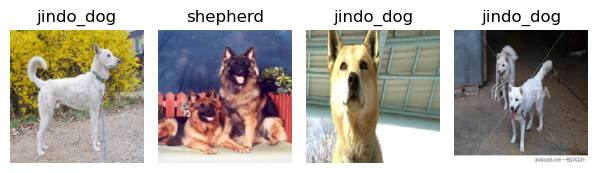

In [65]:
## ImageDataGenerator를 통해 전달된 이미지 출력

data, label = train_generator.next()

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'chihuahua', 1 : 'jindo_dog', 2 : 'shepherd', 3 : 'yorkshire_terrier'}



for i in range(4):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

In [66]:
# 가중치 imagenet으로 설정
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D()) # Flatten() 대신 사용가능

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))



# 4 대신 정답갯수를 알 수 있었던 train_generator.num_classes
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["acc"])

start_time = datetime.now()

save_file_name = 'mydog.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

# epochs = 15
result = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

154/154 [==============================] - 39s 251ms/step - loss: 0.5767 - acc: 0.7964 - val_loss: 0.1968 - val_acc: 0.9512
Epoch 5/10
154/154 [==============================] - ETA: 0s - loss: 0.4906 - acc: 0.8078
Epoch 5: val_loss improved from 0.19679 to 0.14269, saving model to COVID-19_Radiography_MobileNet_Colab.h5
154/154 [==============================] - 39s 253ms/step - loss: 0.4906 - acc: 0.8078 - val_loss: 0.1427 - val_acc: 0.9675
Epoch 6/10
154/154 [==============================] - ETA: 0s - loss: 0.4802 - acc: 0.8322
Epoch 6: val_loss improved from 0.14269 to 0.14010, saving model to COVID-19_Radiography_MobileNet_Colab.h5
154/154 [==============================] - 38s 245ms/step - loss: 0.4802 - acc: 0.8322 - val_loss: 0.1401 - val_acc: 0.9837
Epoch 7/10
154/154 [==============================] - ETA: 0s - loss: 0.4207 - acc: 0.8616
Epoch 7: val_loss did not improve from 0.14010
154/154 [==============================] - 38s 248ms/step - loss: 0.4207 - acc: 0.8616 - val

In [67]:
model.evaluate(test_generator)

31/31 [==============================] - 2s 49ms/step - loss: 0.1686 - acc: 0.9512


[0.1685645580291748, 0.9512194991111755]

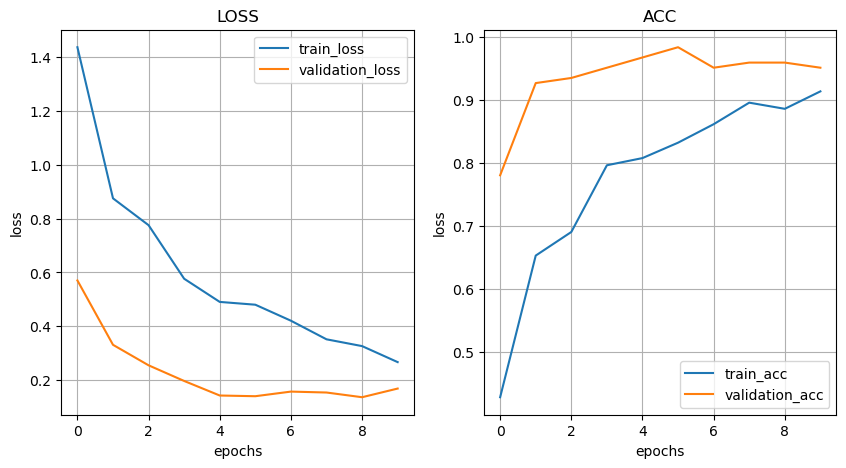

In [68]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [76]:
test_img_list = []

test_img_name_list = glob.glob(TEST_IMAGE_FILE_DATA_ROOT_DIR + "/*/*")

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=[224, 224])
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img/255.0
    test_img_list.append(dst_img)
    
print(test_img_list)

[array([[[0.04313725, 0.06666667, 0.06666667],
        [0.05490196, 0.09019608, 0.08627451],
        [0.06666667, 0.10196078, 0.09803922],
        ...,
        [0.94509804, 0.95686275, 0.98823529],
        [0.80784314, 0.85882353, 0.81960784],
        [0.78431373, 0.85098039, 0.78039216]],

       [[0.04705882, 0.07058824, 0.07058824],
        [0.0627451 , 0.08627451, 0.08627451],
        [0.05882353, 0.09411765, 0.09019608],
        ...,
        [0.89803922, 0.91372549, 0.95294118],
        [0.83529412, 0.89019608, 0.85098039],
        [0.40784314, 0.4745098 , 0.40784314]],

       [[0.0627451 , 0.08627451, 0.08627451],
        [0.07058824, 0.09411765, 0.09411765],
        [0.06666667, 0.09411765, 0.09019608],
        ...,
        [0.74509804, 0.76078431, 0.78823529],
        [0.55686275, 0.60392157, 0.57647059],
        [0.54509804, 0.60392157, 0.55294118]],

       ...,

       [[0.61960784, 0.54901961, 0.44313725],
        [0.61568627, 0.56862745, 0.49803922],
        [0.56862745, 

In [77]:
TEST_IMAGE_FILE_DATA_ROOT_DIR

'content\\mydog\\test_image_files'

In [78]:
pred = model.predict(np.array(test_img_list))
print(pred.shape)
print(pred)

1/1 [==============================] - 6s 6s/step
(29, 4)
[[9.6188450e-01 3.5734579e-02 1.1162530e-03 1.2647132e-03]
 [9.9807239e-01 8.2878466e-04 9.1270922e-04 1.8615156e-04]
 [9.9882191e-01 5.8191380e-04 4.6799911e-04 1.2817154e-04]
 [9.9974996e-01 1.5532243e-04 5.1963034e-05 4.2734493e-05]
 [4.7658038e-01 1.3799019e-01 2.9644343e-01 8.8986024e-02]
 [4.5266590e-09 9.9999988e-01 9.7920797e-08 1.2248068e-08]
 [5.3723637e-05 9.9976057e-01 1.6749129e-04 1.8276054e-05]
 [2.6346964e-04 9.9798870e-01 1.5258373e-03 2.2201226e-04]
 [3.9908668e-05 9.9946576e-01 4.7222199e-04 2.2181253e-05]
 [4.0948253e-06 9.9998093e-01 1.3680551e-05 1.2899546e-06]
 [7.9224837e-06 9.9996173e-01 2.7358556e-05 2.9565279e-06]
 [2.6655332e-03 9.9314368e-01 3.7676773e-03 4.2318314e-04]
 [1.1358831e-05 9.9989903e-01 8.2316459e-05 7.2695402e-06]
 [2.5470643e-03 9.9129033e-01 5.2780122e-03 8.8467868e-04]
 [3.5355915e-06 9.9994802e-01 3.8019894e-05 1.0420878e-05]
 [1.2690760e-04 9.9949682e-01 2.3789229e-04 1.3833483e-04

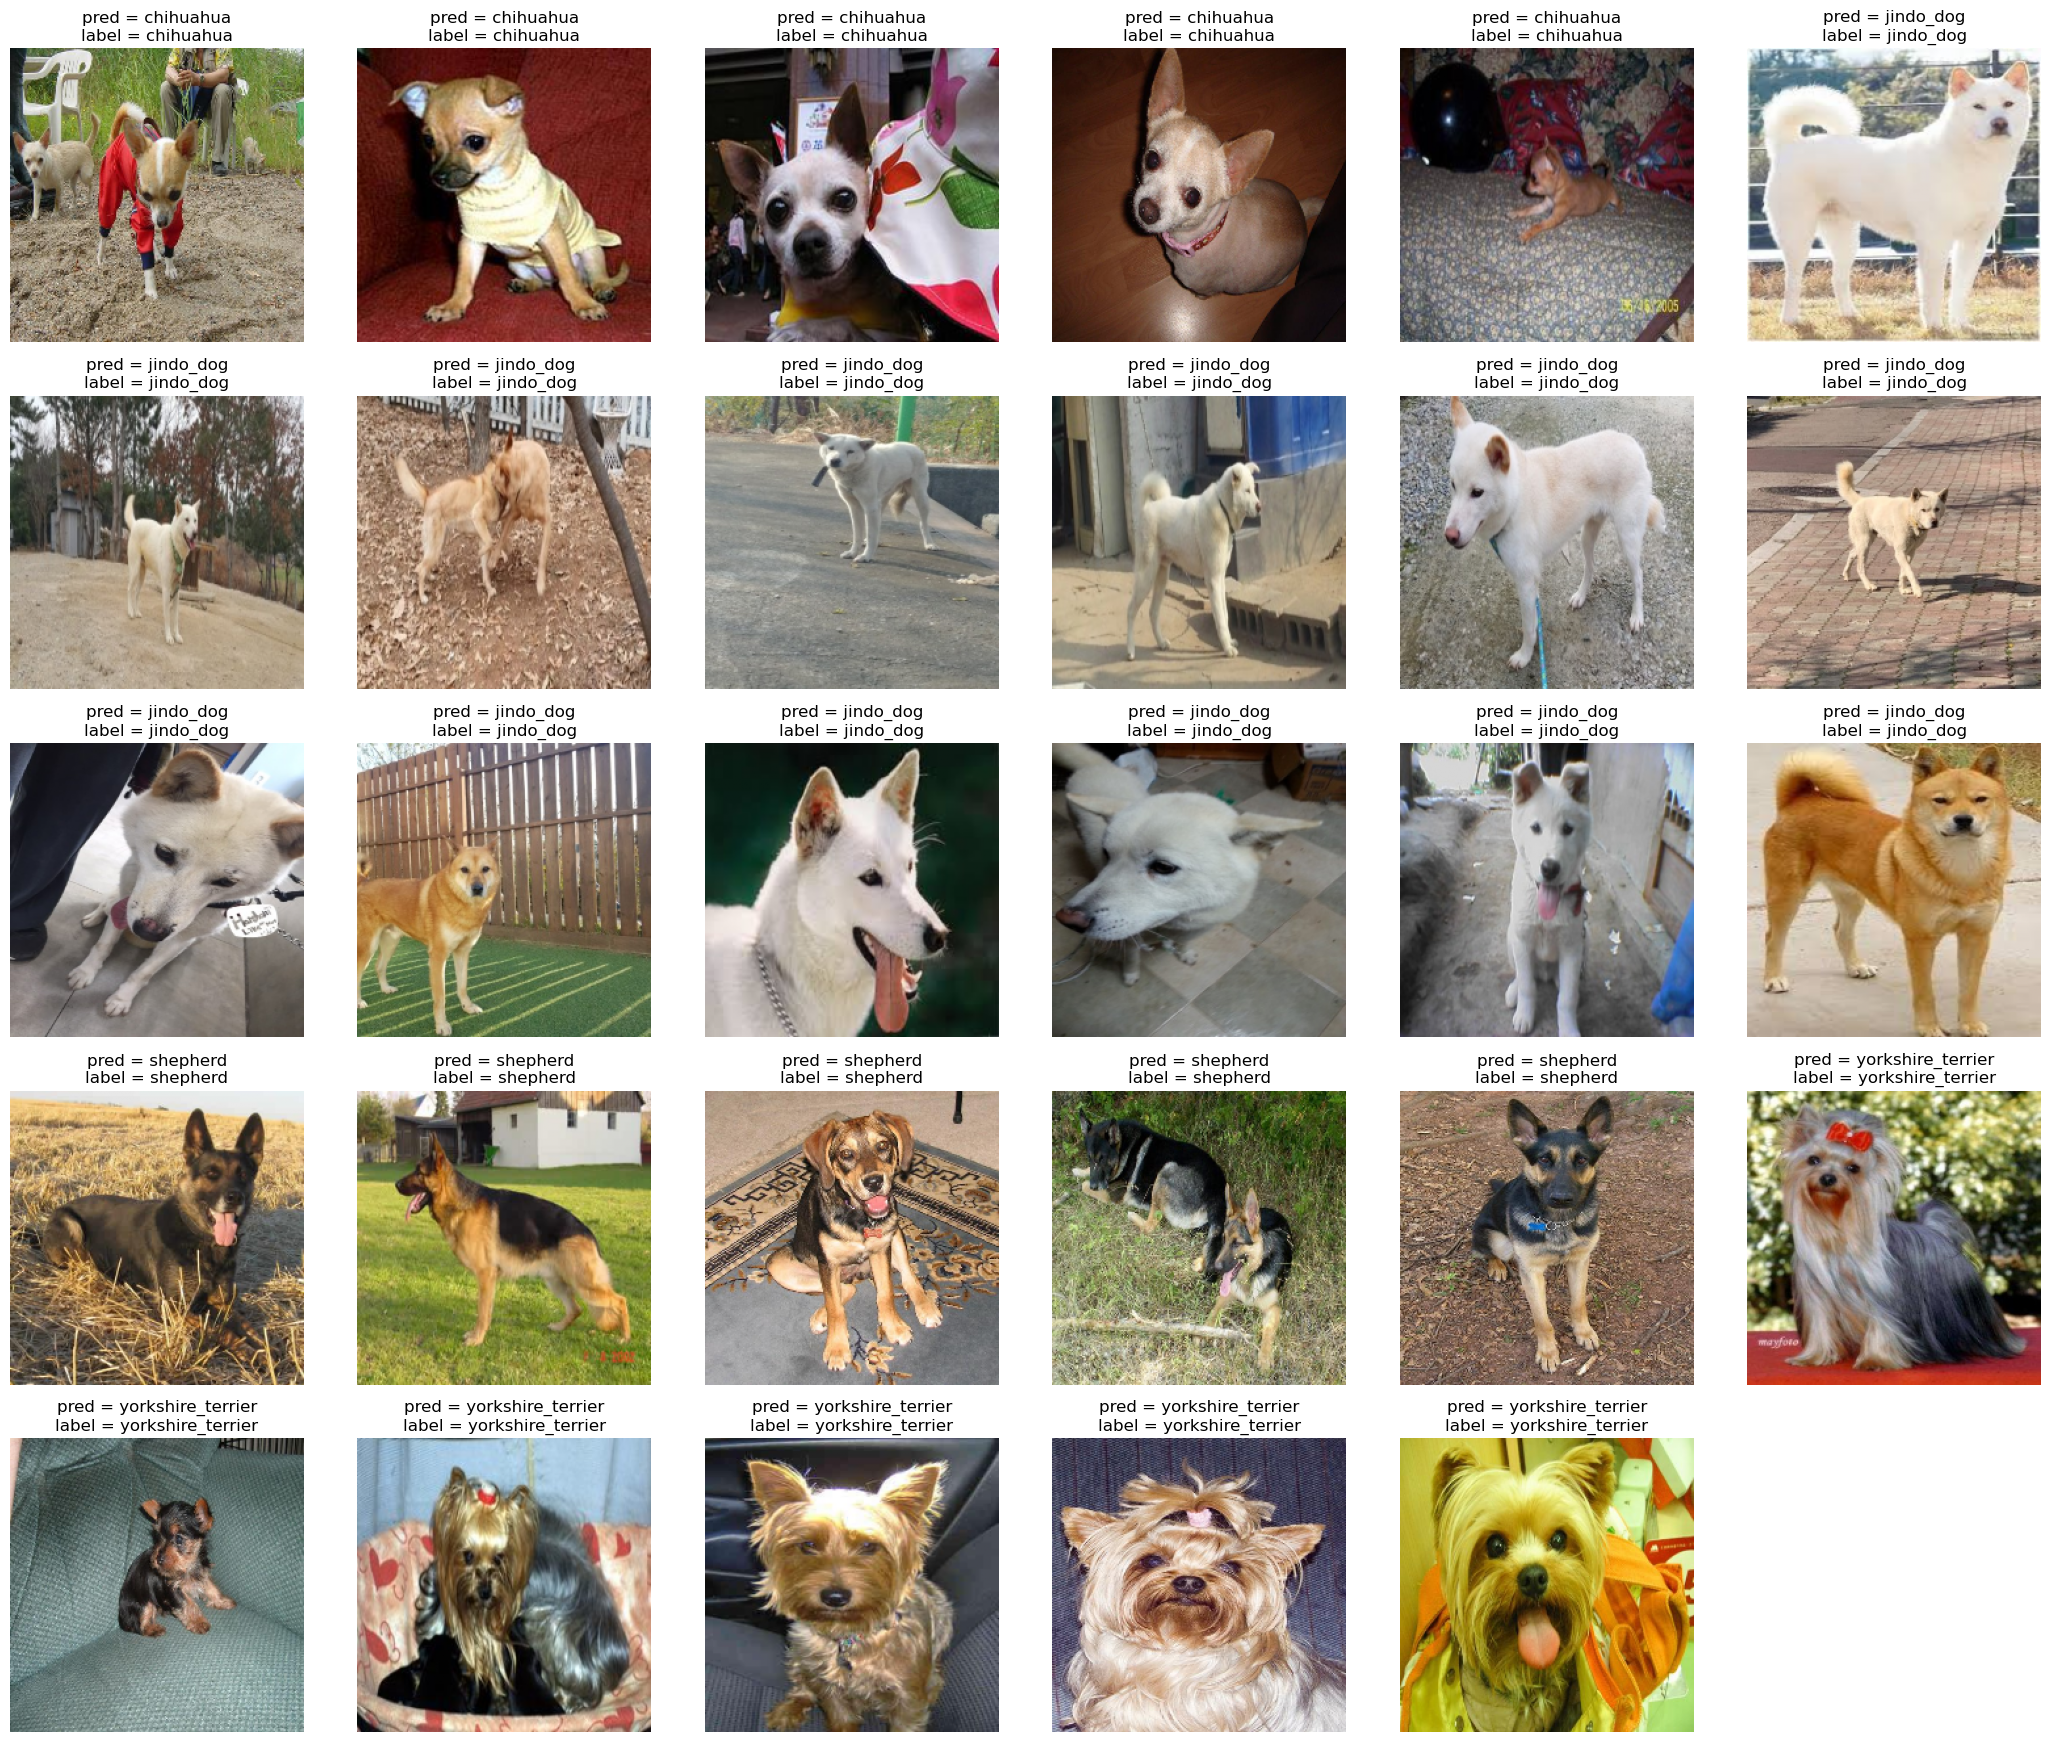

In [136]:
plt.figure(figsize=(21, 21))

class_dict = {0 : 'chihuahua', 1 : 'jindo_dog', 2 : 'shepherd', 3 : 'yorkshire_terrier'}

for i in range(len(pred)):

    plt.subplot(6,6, i+1)
    plt.axis("off")
    
    prob = 1 - pred[i]
    prediction = class_dict[np.argmax(pred[i])]
    plt.imshow(test_img_list[i])
    plt.title(("pred = " + prediction) + "\n" + ("label = " + test_img_name_list[i].split("\\")[3]))
    

plt.tight_layout()